Let's load our recordings and extract the spectrogram from a random recording:

In [15]:
from os import listdir
from random import choice
import pylab
import wave
import numpy as np
#from scipy.io import wavfile

In [16]:
def wavInfo(rec_file):
    wav_file = wave.open(rec_file, 'r')
    frames = wav_file.readframes(-1)
    wave_info = pylab.fromstring(frames, 'Int16') #all .wavs in our dataset are 16bit
    framerate = wav_file.getframerate()
    wav_file.close()
    return wave_info, framerate

In [61]:
 def graphSpec(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    print("Max frequency is %s" % framerate)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.xlabel("Time (s)")
    pylab.ylabel("Frequency (Hz)")
    pylab.subplot(111)
    pylab.title('Spectrogram of %s' % rec_file)
    values, ybins, xbins, im = pylab.specgram(wave_info, NFFT=512, window=pylab.window_hanning, Fs=framerate)
    #pylab.xlim([40,44])
    #pylab.ylim([1800,5400])
    pylab.show()
    return values, ybins, xbins
    #pylab.savefig("%s_spectrogram.png" % rec_file)

Extracting spectrogram from ../dataset/recordings/gb010-2014-10-07_05-40.wav

Max frequency is 44100


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


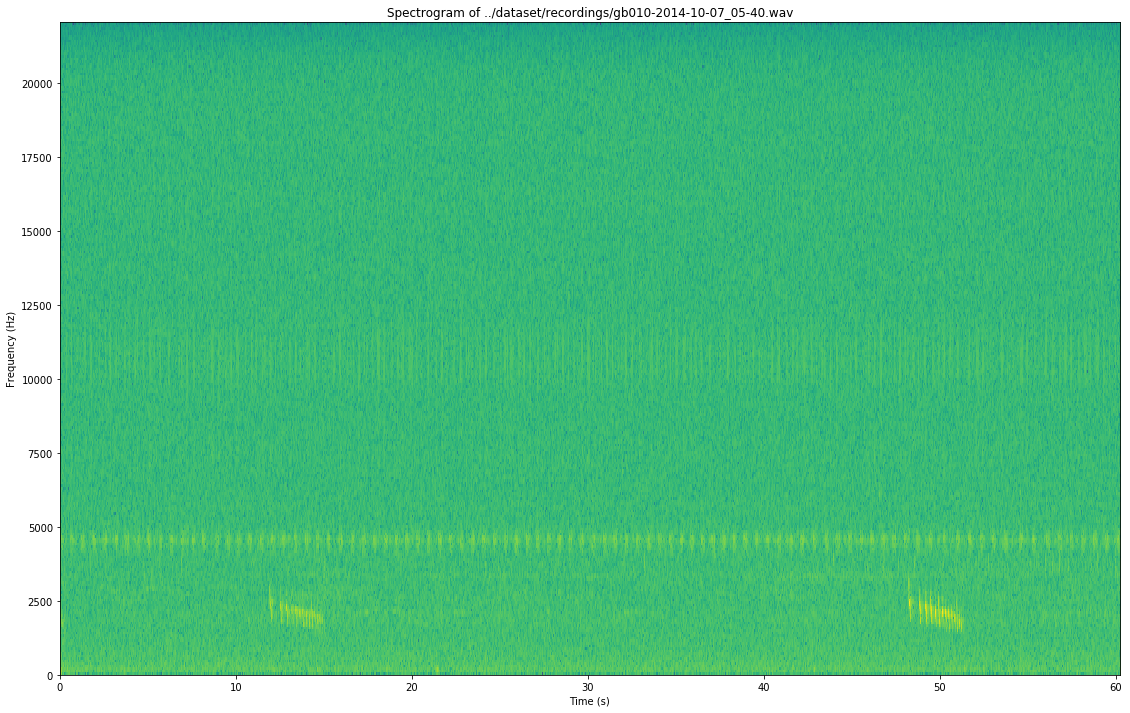

[[  6.42069889e-03   1.62971723e-04   9.17562890e-03 ...,   1.13007416e-06
    2.07455264e-03   1.81160114e-03]
 [  1.89351747e-02   8.01476586e-03   5.04641000e-02 ...,   5.00831313e-05
    1.41773199e-02   8.61802853e-03]
 [  1.13033825e-03   9.95561660e-03   5.39580166e-02 ...,   3.05661735e-03
    2.59800240e-02   1.36787607e-02]
 ..., 
 [  2.45944306e-05   2.33650324e-05   3.85091589e-05 ...,   3.66989998e-05
    8.89754108e-05   9.15996446e-05]
 [  6.24201145e-05   8.08084288e-06   5.87384018e-05 ...,   1.46210681e-05
    3.68444762e-06   1.66141188e-05]
 [  3.12831592e-05   1.82856357e-06   3.24325270e-05 ...,   1.25074471e-06
    5.71277262e-07   1.57634383e-07]]


In [62]:
dataset_dir = '../dataset/recordings/'
recordings = listdir(dataset_dir) #put path to dataset in your machine. not uploading dataset to github
rec_file = dataset_dir + choice(recordings)
print("Extracting spectrogram from %s\n" %(rec_file))
coso, cuestion, vaina = graphSpec(rec_file)
print (coso)

Studying details from ../dataset/recordings/Gb005-2014-09-29_05-10.wav

Max frequency is 44100


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


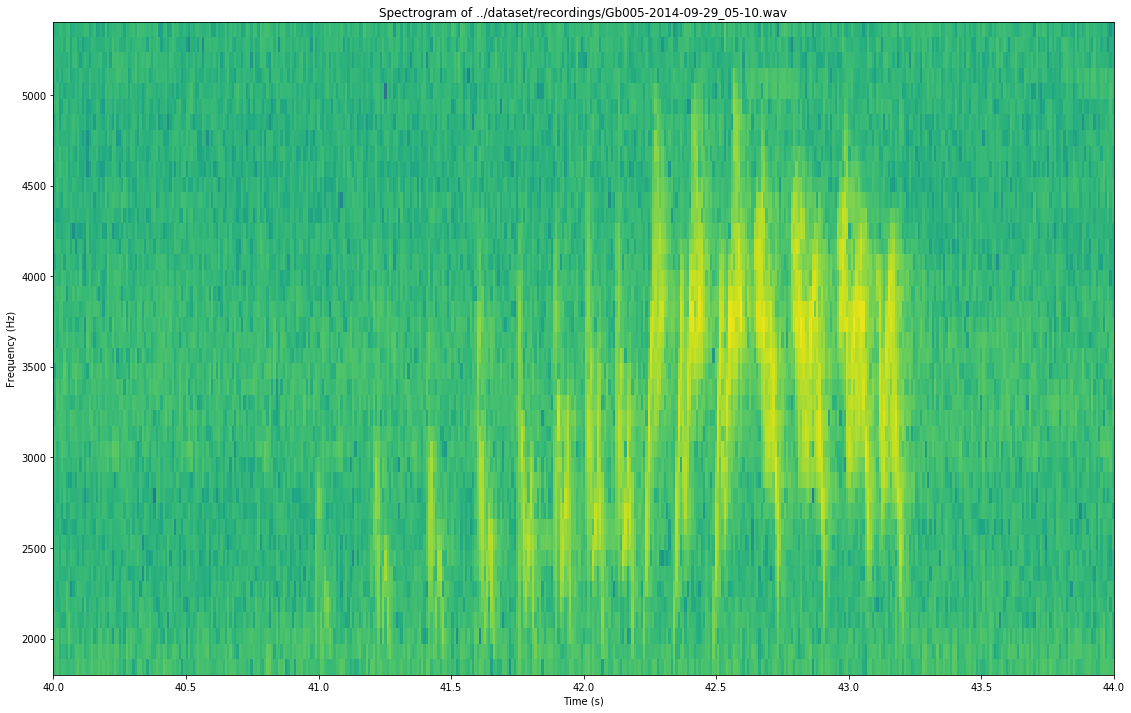

In [56]:
test='../dataset/recordings/Gb005-2014-09-29_05-10.wav'
print("Studying details from %s\n" %(test))
graphSpec(test)

## References:
* [why pylab?](http://stackoverflow.com/questions/23451028/matplotlib-pyplot-vs-matplotlib-pylab)
* [.wav to spectrogram code](http://coreygoldberg.blogspot.com/2013/06/generating-audio-spectrograms-in-python.html)
* [general info about .wav files](https://web.archive.org/web/20140221054954/http://home.roadrunner.com/~jgglatt/tech/wave.htm)